In [27]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from bresenham import bresenham
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
from sklearn.neighbors import KDTree
from planning_utils import heuristic, create_grid
%matplotlib inline 
import sys
# ! pip install -I networkx==2.1
import pkg_resources
# pkg_resources.require("networkx==2.1")
import networkx as nx
print(nx.__version__)
plt.rcParams['figure.figsize'] = 14, 14

2.1


In [5]:
with open("colliders.csv") as datafile:
    line = datafile.readline().strip()

spoint = line.split(', ')
lat0 = float(spoint[0].split(' ')[1])
lon0 = float(spoint[1].split(' ')[1])
print(lat0 , lon0)


37.79248 -122.39745


In [6]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

NameError: name 'TARGET_ALTITUDE' is not defined

In [9]:
# 1.Creating a tree out of obstacles
# 2. Creating polygons from obstacles

polygons = []
centres = []

# minimum and maximum north coordinates
north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))

# minimum and maximum east coordinates
east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))

# given the minimum and maximum coordinates we can
# calculate the size of the grid.
north_size = int(np.ceil(north_max - north_min))
east_size = int(np.ceil(east_max - east_min))

safety_distance = 5

for row in data:
    north, east, alt, d_north, d_east, d_alt = row
        
    c1 = (np.clip(north - d_north - safety_distance - north_min, 0, north_size-1)\
          ,np.clip(east - d_east - safety_distance - east_min, 0, east_size-1 ))
  
    c2 = (np.clip(north - d_north - safety_distance - north_min, 0, north_size-1)\
       ,np.clip(east + d_east + safety_distance - east_min, 0, east_size-1 ))    
        
    c3 = (np.clip(north + d_north + safety_distance - north_min, 0, north_size-1)\
          ,np.clip(east + d_east + safety_distance - east_min, 0, east_size-1 ))

    c4 = (np.clip(north + d_north + safety_distance - north_min, 0, north_size-1)\
          ,np.clip(east - d_east - safety_distance - east_min, 0, east_size-1 ))
     
    poly = Polygon([c1, c2, c3, c4])
    polygons.append((poly , alt + d_alt))
    centres.append((poly.centroid.x, poly.centroid.y))
    
tree = KDTree(centres, metric = 'euclidean')


In [19]:
 grid, north_offset, east_offset = create_grid(data, 5, safety_distance)

In [13]:
#Random sampling:
## 1) Choosing 300 random points across the grid
## 2) Filtering points which conflict with obstacles

n_samples = 300

max_xy = 2 * np.max((data[:,3], data[:,4]))

random_x = np.random.uniform(north_min, north_max, n_samples)
random_y = np.random.uniform(east_min, east_max, n_samples)
random_z = np.random.uniform(0, 5, n_samples)
sample_data = list(zip(random_x, random_y, random_z))

colFree_samples = []

for sample in sample_data:
    near_centres = list(tree.query_radius(np.array([sample[0],sample[1]]).reshape(1,-1), r=max_xy)[0])
    collision = False
    for ind in near_centres:
        pg , height = polygons[ind]
        collision = (pg.contains(Point(sample))and height >= sample[2])
    if not collision:
        colFree_samples.append(sample)

print(len(colFree_samples))      

248


In [28]:
# A* algorithm
from queue import PriorityQueue

def heuristic(n1, n2):
    return LA.norm(np.array(n2) - np.array(n1))

def a_star(graph, h, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                branch_cost = current_cost + cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)
                    branch[next_node] = (branch_cost, current_node)
                    queue.put((queue_cost, next_node))
                    
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost


In [17]:
# Extracting a graph out of collision-free sample points
## 1) Creating a tree out of col-free sample points
## 2) Check what pair of nodes can connect

sample_tree = KDTree(colFree_samples)

def can_connect(n1, n2, polygons):
    line = LineString([n1, n2])
    can_conn = True
    for pg,hei in polygons:
        can_conn = ( pg.crosses(line) and hei >= min(n1[2], n2[2]))
        if not can_connect:
            return False
    return True

def create_graph(col_free_samples, sample_tree):
    graph = nx.Graph()
    for sample in col_free_samples:
        qnodes = list(sample_tree.query([sample], k=10, return_distance = False)[0])
        for node_ind in qnodes:
            if can_connect(sample, colFree_samples[node_ind], polygons):
                graph.add_edge(sample, colFree_samples[node_ind], weight=1)
    return graph    

graph = create_graph(colFree_samples, sample_tree)

In [29]:
start = colFree_samples[np.random.randint(len(colFree_samples))]
goal = colFree_samples[np.random.randint(len(colFree_samples))]
print (start , goal)

(-244.64719314388617, -323.8081774163561, 2.9220662750920057) (-292.9855797821142, -208.20030359831847, 3.6117581840823441)


In [30]:
path , cost = a_star(graph, heuristic, start, goal)

Found a path.


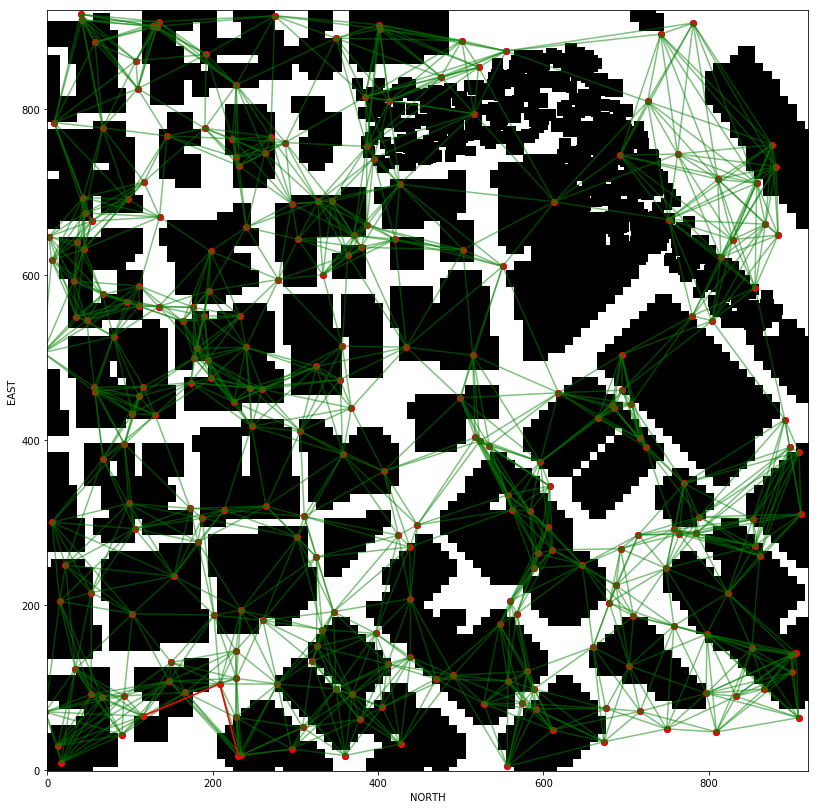

In [31]:
fig = plt.figure()



nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw edges
for (n1, n2) in graph.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green' , alpha=0.5)

# draw all nodes
for n1 in colFree_samples:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# draw connected nodes
for n1 in graph.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
    
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'red')

plt.imshow(grid, cmap='Greys', origin='lower')

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()